In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds

%matplotlib notebook

# import our datasets (MovieLens 1M Dataset)
# contains 1 million ratings from 6000 users on 4000 movies
ratings_list = [i.strip().split("::") for i in open('./datasets/ratings.dat', 'r').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns=['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype=int)

movies_list = [i.strip().split("::") for i in open('./datasets/movies.dat', 'r', errors='ignore').readlines()]
movies_df = pd.DataFrame(movies_list, columns=['MovieID', 'Title', 'Genres'])

users_list = [i.strip().split("::") for i in open ('./datasets/users.dat', 'r').readlines()]

In [ ]:
# contains data about users, and their movie ratings
ratings_df.head(10)

In [ ]:
# provides data about movie titles
movies_df.head(10)

In [ ]:
# from the two dataframes, create a matrix where each row=userId and each column=movieId
# since we'll be using SVD and this will act as our R, we'll name it R_df

# we'll also fill all the empty values with zeros to make our matrix dense
# a better approach will be to use a minimization function on the errors between the predicted and
# known values, but we will just use zeros for the sake of simplicity

R_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
R_df.head(10)

In [ ]:
# normalize the data according to each user's mean. this is still not as good as 
# using optimization to obtain the values, but hopefully this will be better than just zeros

# when reshaping, a dimension of -1 means that the value is inferred from the length of the array
# and remaining dimensions

R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [ ]:
# apply the SVD algorithm, which will give us three vectors
# k is the number of latent features to extract from the dataset
# k is also another variable that we can possibly optimize
# we'll also need to turn sigma into a diagonal matrix for our predictions


K_FACTOR = 50

U, sigma, Vt = svds(R_demeaned, k=K_FACTOR)
sigma = np.diag(sigma)

In [ ]:
# since we de-meaned the dataset before applying SVD, we need to add the mean back to get predictions

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predictions_df = pd.DataFrame(all_user_predicted_ratings, columns=R_df.columns)

predictions_df.head(10)

In [ ]:
# now we'll write a function that takes as input userID and n number of recommendations, 
# and will return the top n-recommendations along with a already-rated items

NUM_REC = 10

def recommend_movies(userID, name, num_rec=NUM_REC):
    user_row_number = userID - 1 # iloc uses purely integer-location based indexing, and userID starts at 1, not 0
    
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    sorted_user_predictions_df = pd.DataFrame(sorted_user_predictions).reset_index()
    
    # both columns in the merge need to be the same dtype, or it can lead to errors
    # so we'll convert MovieID in movies_df to numeric
    movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
    user_data = ratings_df[ratings_df.UserID == (userID)]
    already_rated = user_data.merge(movies_df, how='left', left_on='MovieID', right_on='MovieID').sort_values(['Rating'], ascending=False)
    print("{} has already rated {} movies.".format(name, already_rated.shape[0]))
    print("Recommending the highest {} predicted ratings for unseen movies.".format(num_rec))
    
    predictions = movies_df[~movies_df['MovieID'].isin(already_rated['MovieID'])]
    predictions = predictions.merge(sorted_user_predictions_df, how='left', left_on='MovieID', right_on='MovieID')
    predictions = predictions.rename(columns = {user_row_number:'Predictions'}).sort_values('Predictions', ascending=False)
    
    return already_rated, predictions
    

In [ ]:
# visualize the output
def show_predictions(name, predictions):
    sorted_predicted_ratings = []
    sorted_titles = []

    movie_rank = 1
    for idx, row in predictions[:NUM_REC].iterrows():
        sorted_predicted_ratings.append(row['Predictions'])
        sorted_titles.append("{}\t[{}]\t{}".format(movie_rank, round(row['Predictions'], 3), row['Title']))
        movie_rank += 1

    plt.figure()
    plt.bar(range(10), sorted_predicted_ratings, width=0.35, align='center', color='#8ACA9B', edgecolor='black', tick_label=range(1,11))
    plt.title("Top {} Predicted Recommendations for {}".format(NUM_REC, name))
    plt.xlabel("Movie")
    plt.ylabel("Predicted Rating")
    plt.ylim(ymax=sorted_predicted_ratings[0] * 1.2)
    plt.show()
    
    for title in sorted_titles:
        print(title)

In [16]:
# 837: Nancy
already_rated, predictions = recommend_movies(837, "Nancy")
already_rated.head(10)

Nancy has already rated 69 movies.
Recommending the highest 10 predicted ratings for unseen movies.


,UserID,MovieID,Rating,Timestamp,Title,Genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


<IPython.core.display.Javascript object>


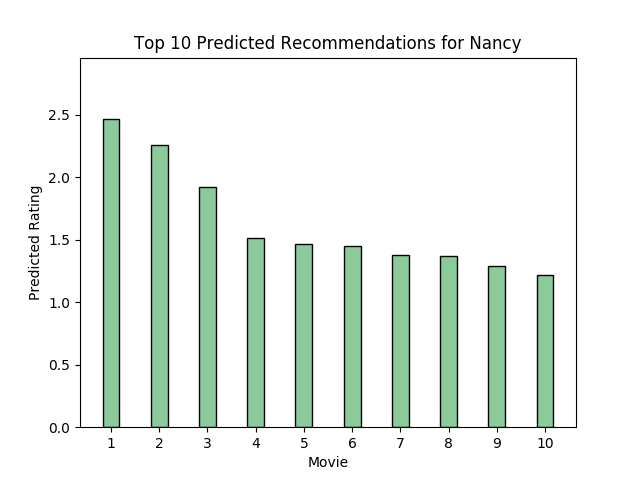

1	[2.463]	Schindler's List (1993)
2	[2.259]	French Connection, The (1971)
3	[1.918]	Fargo (1996)
4	[1.515]	Big Sleep, The (1946)
5	[1.467]	Untouchables, The (1987)
6	[1.448]	Annie Hall (1977)
7	[1.378]	Glory (1989)
8	[1.37]	Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
9	[1.293]	Rocky (1976)
10	[1.217]	Silence of the Lambs, The (1991)


In [17]:
show_predictions("Nancy", predictions)

In [ ]:
# 342: Billy
already_rated, predictions = recommend_movies(342, "Billy")
already_rated.head(10)

In [ ]:
show_predictions("Billy", predictions)

In [ ]:
# 22: Carl
already_rated, predictions = recommend_movies(22, "Carl")
already_rated.head(10)

In [ ]:
show_predictions("Carl", predictions)